In [43]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
#assumes trail files are stored in simData folder 
#and simData folder in current directory
from scipy.integrate import odeint
%matplotlib inline

In [2]:
def states_to_pop(log_path): 
    # This function processes the data resulting from the simulation
    # which contain the states of each node at each timestep
    # It returns dataframes with information about the total population
    # at each timestep for each trial.

    files=os.listdir(log_path) #get all files current directory
    files = [f for f in files if 'trial' in f] #only keep files with 'trial' in them
    files.sort() #sorting
    zombies = pd.DataFrame(columns=range(10),index=range(500))
    humans = pd.DataFrame(columns=range(10),index=range(500))
    removed = pd.DataFrame(columns=range(10),index=range(500))
    num_trials = len(files)
    for k in range(num_trials):

        item = files[k]
        states=pd.DataFrame.from_csv(log_path+'/'+item) #This is the dataframe with all the states
        
        time_steps=(len(states.columns))#time steps at which we have recorded population
        a=range(time_steps)#makes a list with time intervals
        states.columns=a #relabels the columns so that they correspond to steps all integers
        humans[k] = (states == 0).sum()
        zombies[k] = (states == 1.0).sum()
        removed[k] = (states == 2.0).sum()
        
    return humans.T,zombies.T,removed.T
    

In [181]:
S,Z,R = states_to_pop('BA2data')

In [146]:
def plot_results(S,Z,R):
    #Given population data this function produces a plot with their
    #behaviour over time averaged over the number of trials.
    
    t = S.columns
    plt.plot(t,S.mean(),color='b',label='S')
    plt.fill_between(t,S.mean()-S.std(),S.mean()+S.std(),color='b',alpha=0.2)
    plt.plot(t,Z.mean(),color='r',label='Z')
    plt.fill_between(t,Z.mean()-Z.std(),Z.mean()+Z.std(),color='r',alpha=0.2)
    plt.plot(t,R.mean(),color='k',label='R')
    plt.fill_between(t,R.mean()-R.std(),R.mean()+R.std(),color='k',alpha=0.2)
    
    axis = plt.gca()
    axis.set_ylim([0,1000])
    axis.set_xlim([0,500])
    plt.legend()
    plt.xlabel('t',fontsize = 20)
    plt.ylabel('population', fontsize = 18)

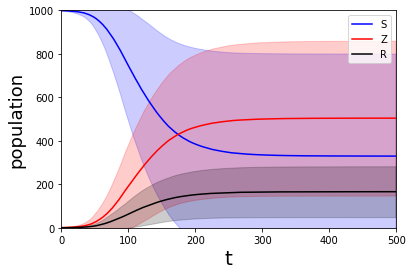

In [147]:
plot_results(S,Z,R)

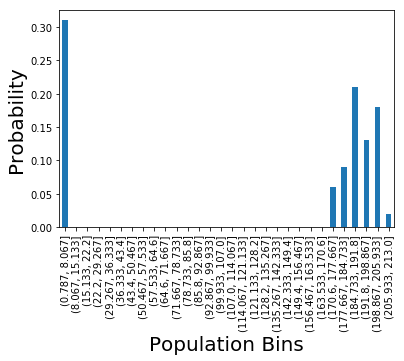

In [120]:
#Histogramming the distribution of the population over different trials
#for a specific point at time

a = pd.value_counts(R[499],bins = 30,sort=False,normalize=True)
a.plot(kind='bar')
plt.xlabel('Population Bins', fontsize = 20)
plt.ylabel('Probability', fontsize = 20)

In [56]:
def plot_random_trial(log_path):
    files=os.listdir(log_path) #get all files current directory
    files = [f for f in files if 'trial' in f]
    item = np.random.choice(files) #randomly choose a trial
    states=pd.DataFrame.from_csv(log_path+'/'+item)
    time_steps=(len(states.columns))#time steps at which we have recorded population
    a=range(time_steps)#makes a list with time intervals
    states.columns=a #relabels the columns so that they correspond to steps all integers
    S = (states == 0).sum()
    Z = (states == 1.0).sum()
    R = (states == 2.0).sum()
    plt.plot(a,S,color='b',label='S')
    plt.plot(a,Z,color='r',label='Z')
    plt.plot(a,R,color='k',label='R')
    plt.legend()
    plt.title('Population behaviour for one trial')
    plt.xlabel('Time')
    plt.ylabel('Population')

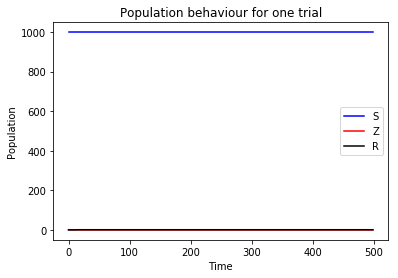

In [126]:
plot_random_trial('BA15data')

# Simplified SZR differential equations:
I wanted to compare the trial runs to the coupled differential equation system we used at the start of the project.
## $$ \dot S = - \beta SZ$$
## $$ \dot Z = (\beta - \kappa)SZ$$
## $$ \dot R = \kappa SZ$$
### Where $\kappa$ is the killing rate and $\beta$ is the biting rate

In [41]:
def SZR(y,t,b,k):
    
    dydt = [0] * 3
    
    #y[0] = S, y[1] = Z, y[2] = R
    
    dydt[0] = - b * y[0] * y[1]
    dydt[1] =  (b - k) * y[0] * y[1]
    dydt[2] = k * y[0] * y[1]
    
    return dydt

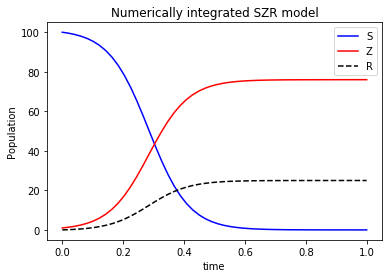

In [54]:
#Set initial Conditions
y0 =[100,1,0]
t = np.linspace(0,1)
b = 0.2
k = 0.05
#Solve
y = odeint(SZR, y0, t,args=(b,k))
#Plot
plt.plot(t,y[:,0],'-b',label='S')
plt.plot(t,y[:,1],'-r',label='Z')
plt.plot(t,y[:,2],'--k',label='R')
plt.legend()
plt.title('Numerically integrated SZR model')
plt.xlabel('time')
plt.ylabel('Population')

By inspecting individual trials we discovered that the system does not reach a steady state but instead the trials where the humans kill off all the zombies at the very start of the trial skew the results.
For this reason we decided to plot only the trials where there is at least one zombie alive at the end of the simulation.

In [178]:
def remove_trials_where_humans_win(S,Z,R):
    acceptable_trials = Z[499] != 0 
    S_new = S[acceptable_trials]
    Z_new = Z[acceptable_trials]
    R_new = R[acceptable_trials]
    return S_new , Z_new, R_new

def remove_trials_where_zombies_win(S,Z,R):
    acceptable_trials = Z[499] == 0 
    S_new = S[acceptable_trials]
    Z_new = Z[acceptable_trials]
    R_new = R[acceptable_trials]
    return S_new , Z_new, R_new

Want to see how many there were in the failed apocalypses.

3

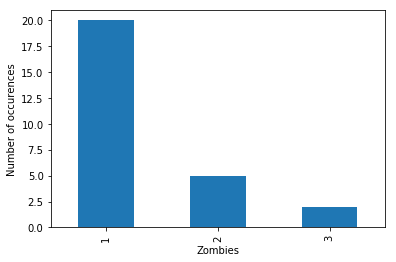

In [187]:
S1,Z1,R1 = remove_trials_where_zombies_win(S,Z,R)

R_dist = pd.value_counts(R1[499],sort=False)
R_dist.plot(kind='bar')
plt.xlabel('Zombies')
plt.ylabel('Number of occurences')
np.max(R1[499])

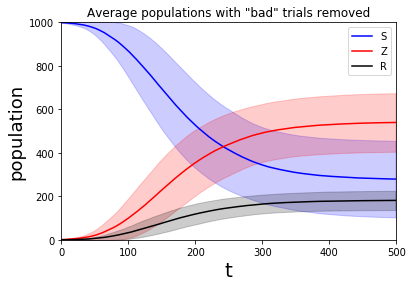

In [184]:

S2,Z2,R2 = remove_trials_where_humans_win(S,Z,R)
plot_results(S2,Z2,R2)
plt.title('Average populations with "bad" trials removed')
